In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import scipy.linalg

#%% parameters -------------------------------------------------------------------------------
n_test = 100
n_train_max  = 1800  # this has to be larger than 4**n_qubits
n_qubits = 2
reps = 5

In [ ]:
#%%


#%% functions to generate data ---------------------------------------------------------------
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)

# map data in [0,1] range
X = X / 255.0

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000)

# standardize data -- make mean 0 and std 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# choose only two classes '0' and '1' for now
train_filter = np.where((y_train == '0') | (y_train == '1'))
test_filter = np.where((y_test == '0') | (y_test == '1'))

# reduced training and test data with only 2 classes
x_train_red, y_train_red = X_train[train_filter], y_train[train_filter]
x_test_red, y_test_red = X_test[test_filter], y_test[test_filter]

# Reshape labels to one-hot encode them
y_train_red = y_train_red.reshape(-1, 1)
y_test_red = y_test_red.reshape(-1, 1)

# One-hot encode the labels
ohe = OneHotEncoder()
ohe.fit(y_train_red)
y_train = ohe.transform(y_train_red).toarray()
ohe.fit(y_test_red)
y_test = ohe.transform(y_test_red).toarray()

from sklearn.decomposition import PCA

# Initialize PCA with the number of components
to_use = 2 * n_qubits
pca = PCA(n_components=to_use)

# Fit the PCA model and transform the data
x_train = pca.fit_transform(x_train_red)
x_test = pca.transform(x_test_red)

# choose only subset of data
x_test = x_test[:n_test]
y_test = y_test[:n_test]

#%% define quantum kernel functions -------------------------------------------------------
def quantum_feature_map(x):
    """
    Feature map for quantum kernel.
    Adjust repetitions (reps) or gates if kernel is not full rank.
    """
    reps = n_qubits
    for r in range(reps):
        for i in range(len(x)):
            qml.RX(x[i], wires=i % n_qubits)
        for n in range(n_qubits - 1):
            qml.CNOT(wires=[n, n + 1])
        for i in range(len(x)):
            qml.RZ(x[i], wires=i % n_qubits)

dev_kernel = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_kernel)
def kernel_state(x1):
    """
    Takes as input data and returns density matrix.
    Use this function to generate rho(X).
    """
    quantum_feature_map(x1)
    return qml.density_matrix(wires=range(n_qubits))

projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    quantum_feature_map(x1)
    qml.adjoint(quantum_feature_map)(x2)
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

#%% loop over different number of train data -------------------------------------------------
mse_arr = [[] for _ in range(reps)]
mse_arr_train = [[] for _ in range(reps)]
eig_vals_arr = [[] for _ in range(reps)]
cond_no_arr = [[] for _ in range(reps)]
rank_arr = [[] for _ in range(reps)]
params = [[] for _ in range(reps)]
K_train_arr = []

for r in range(reps):
    print("rep:", r + 1, "/", reps)
    x_train_max = x_train[r * n_train_max:(r + 1) * n_train_max]
    y_train_max = y_train[r * n_train_max:(r + 1) * n_train_max]

    if n_qubits == 1:
        limit_low, limit_up, step = 1, 8, 1
    elif n_qubits == 2:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 10, 2**(2 * n_qubits) + 11, 2
    elif n_qubits == 3:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 60, 2**(2 * n_qubits) + 61, 20
    elif n_qubits == 4:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 180, 2**(2 * n_qubits) + 181, 60
    elif n_qubits == 5:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 720, 2**(2 * n_qubits) + 721, 240

    for n_train in range(limit_low, limit_up, step):
        x_train_krr = x_train_max[:n_train]
        y_train_krr = y_train_max[:n_train]
        print(r + 1, ": train samples: ", x_train_krr.shape[0], "/", limit_up - 1)

        K_train = kernel_matrix(x_train_krr, x_train_krr).astype(np.float64)
        K_test = kernel_matrix(x_test, x_train_krr).astype(np.float64)
        K_train_arr.append(K_train)

        kernel_ridge_model = KernelRidge(kernel='precomputed', alpha=0.0)
        kernel_ridge_model.fit(K_train, y_train_krr)

        predictions = kernel_ridge_model.predict(K_test)
        train_predictions = kernel_ridge_model.predict(K_train)

        params[r].append(kernel_ridge_model.dual_coef_)

        K_eig_vals = np.linalg.eig(K_train)[0]
        cond_no = np.linalg.cond(K_train)
        rank = np.linalg.matrix_rank(K_train)

        eig_vals_arr[r].append(K_eig_vals)
        cond_no_arr[r].append(cond_no)
        rank_arr[r].append(rank)
        print("Rank of Kernel: ", rank)

        mse = mean_squared_error(np.real(y_test), predictions)
        mse_arr[r].append(mse)
        print("Mean Squared Error Test:", mse)

        train_mse = mean_squared_error(y_train_krr, train_predictions)
        mse_arr_train[r].append(train_mse)
        print("Mean Squared Error Train:", train_mse)
        print("*" * 50)

mse_arr = np.array(mse_arr)

# %% plot mse for varying number of train samples -----------------------------------------------------------------------
mse_mean = np.mean(mse_arr, axis=0, dtype=np.float64)
mse_std = np.std(mse_arr, axis=0) / np.log(10)

mse_mean_train = np.mean(mse_arr_train, axis=0)
mse_std_train = np.std(mse_arr_train, axis=0)

np.savetxt(f"mse_mean_nqubits_{n_qubits}_MNIST_Fashion", [mse_mean], newline='')
np.savetxt(f"mse_std_nqubits_{n_qubits}_MNIST_Fashion", [mse_std], newline='')
np.savetxt(f"mse_mean_train_nqubits_{n_qubits}_MNIST_Fashion", [mse_mean_train], newline='')
np.savetxt(f"mse_std_train_nqubits_{n_qubits}_MNIST_Fashion", [mse_std_train], newline='')
np.savetxt(f"arrange_nqubits_{n_qubits}_MNIST_Fashion", [np.arange(limit_low, limit_up, step)], newline='')

rep: 1 / 5
1 : train samples:  6 / 26
Rank of Kernel:  6
Mean Squared Error Test: 0.6484164348263926
Mean Squared Error Train: 1.1924776129262776e-29
**************************************************
1 : train samples:  8 / 26
Rank of Kernel:  8
Mean Squared Error Test: 0.680182374769797
Mean Squared Error Train: 1.5951681011492798e-29
**************************************************
1 : train samples:  10 / 26
Rank of Kernel:  10
Mean Squared Error Test: 0.6453142026126211
Mean Squared Error Train: 2.4439766775451523e-29
**************************************************
1 : train samples:  12 / 26
Rank of Kernel:  12
Mean Squared Error Test: 31.901634293092602
Mean Squared Error Train: 4.8913892194183757e-26
**************************************************
1 : train samples:  14 / 26
Rank of Kernel:  14
Mean Squared Error Test: 32.99640622507856
Mean Squared Error Train: 6.118154760395454e-26
**************************************************
1 : train samples:  16 / 26
Rank of 

c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  16
Mean Squared Error Test: 1.8159336420011978
Mean Squared Error Train: 0.025737367565731313
**************************************************
1 : train samples:  20 / 26


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  16
Mean Squared Error Test: 1.2251832796561617
Mean Squared Error Train: 0.03347926936471201
**************************************************
1 : train samples:  22 / 26


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  16
Mean Squared Error Test: 1.3066272392635323
Mean Squared Error Train: 0.03739870579096467
**************************************************
1 : train samples:  24 / 26


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  16
Mean Squared Error Test: 0.9533953935234503
Mean Squared Error Train: 0.0398870867557844
**************************************************
1 : train samples:  26 / 26


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  16
Mean Squared Error Test: 0.9407369055981896
Mean Squared Error Train: 0.04919119470821619
**************************************************
rep: 2 / 5
2 : train samples:  6 / 26
Rank of Kernel:  6
Mean Squared Error Test: 0.48507223693050006
Mean Squared Error Train: 6.210014682054585e-32
**************************************************
2 : train samples:  8 / 26
Rank of Kernel:  8
Mean Squared Error Test: 0.6080557316243876
Mean Squared Error Train: 1.0274051117996246e-30
**************************************************
2 : train samples:  10 / 26
Rank of Kernel:  10
Mean Squared Error Test: 1.848995978151406
Mean Squared Error Train: 4.840288211813809e-29
**************************************************
2 : train samples:  12 / 26
Rank of Kernel:  12
Mean Squared Error Test: 2.411047179315302
Mean Squared Error Train: 5.740511693509389e-29
**************************************************
2 : train samples:  14 / 26
Rank of Kernel:  14
Mean Squared Error T

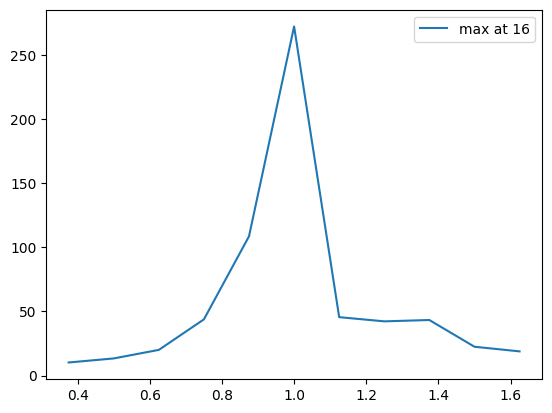

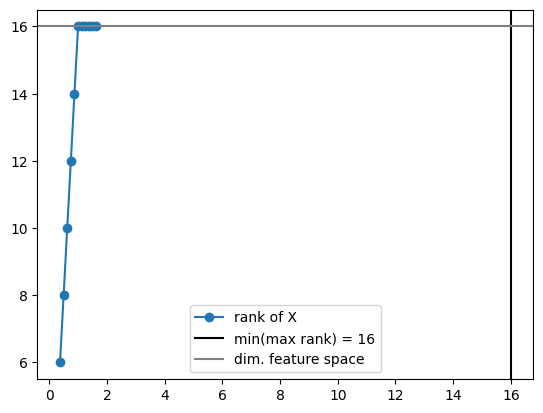

16 /  16


In [ ]:
# compute data matrix condition number and rank -------------------------------------------------------------------
@qml.qnode(dev_kernel)
def kernel_state(x1):
    """The quantum data encoding."""
    quantum_feature_map(x1)
    return qml.density_matrix(wires=range(n_qubits))

def compute_rank(A, tol=None):
    U, s, Vh = scipy.linalg.svd(A)
    if tol is None:
        tol = max(A.shape) * np.spacing(np.max(s))
    rank = np.sum(s > tol)
    return rank

no_train = 2**(2*n_qubits)

cond_no_arr = []
rank_arr = []
for n in range(limit_low, limit_up, step):
    X = [kernel_state(x_train_max[m, :]).flatten().astype(np.complex128) for m in range(n)]
    cond_no = np.linalg.cond(X)
    cond_no_arr.append(cond_no)
    rank_arr.append(compute_rank(np.array(X)))

graph_directory = "Graphs"
scenario = "MNIST_Fashion" +"_nqubits_" + str(n_qubits)
plt.plot(np.arange(limit_low, limit_up, step)/4**n_qubits, cond_no_arr, label=f"max at {range(limit_low, limit_up, step)[np.argmax(cond_no_arr)]}")
plt.legend()

plt.savefig(f"../{graph_directory}/{scenario}_1.png", dpi=500, bbox_inches='tight')
plt.show()

np.savetxt(f"cond_no_arr_nqubits_{n_qubits}MNIST_Fashion", [cond_no_arr], newline='')

plt.plot(np.arange(limit_low, limit_up, step)/4**n_qubits, rank_arr, label="rank of X", marker="o")
plt.axvline(range(limit_low, limit_up, step)[np.min(np.where(np.array(rank_arr) == np.max(np.array(rank_arr))))], label=f"min(max rank) = {range(limit_low, limit_up, step)[np.min(np.where(np.array(rank_arr) == np.max(np.array(rank_arr))))]}", color="black")
plt.axhline(no_train, color="grey", label="dim. feature space")
plt.legend()
plt.savefig(f"../{graph_directory}/{scenario}_2.png", dpi=500, bbox_inches='tight')
plt.show()

np.savetxt(f"rank_arr_nqubits_{n_qubits}MNIST_Fashion", [rank_arr], newline='')

rank = np.linalg.matrix_rank(X)
print(rank, "/ ", no_train)


In [ ]:
print(limit_up/4**n_qubits)

In [ ]:
print(limit_up/4**n_qubits)

1.6875
